## Introduction
This notebook outlines the steps for analyzing customer feedback with the aim of identifying key themes in unsatisfactory responses. We use NLP techniques such as TF-IDF vectorization for feature extraction and K-means clustering to group similar feedback together. This helps in understanding common issues reported by users and guiding improvements in customer service strategies.

## Setup and Configuration
Import all necessary libraries and download required NLTK resources to process the textual data. Ensure all dependencies are correctly installed in your Python environment before proceeding.

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import math

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data Loading and Initial Exploration
Load the dataset and inspect its structure to understand the available data and identify the relevant columns for analysis.

In [9]:
# Load dataset
dataset = pd.read_csv('/content/CustomLeaderAIResponseTestOutput.csv')

# Print column names to identify the correct ones
print("Column names in dataset:", dataset.columns.tolist())

Column names in dataset: ['Model Context', 'Response ', 'Response Score (1 to 10) 1 is poor and 10 is excellent', 'Additional Feedback']


## Data Preprocessing
Calculate the mean score to determine a cutoff for unsatisfactory responses. Also, preprocess the text data by tokenizing, removing stopwords, and applying lemmatization.

In [12]:
dataset_mean = dataset['Response Score (1 to 10) 1 is poor and 10 is excellent'].mean()
cutoff = math.ceil(dataset_mean)
unsatisfactory_answers = dataset[dataset['Response Score (1 to 10) 1 is poor and 10 is excellent'] < cutoff]
reasons = unsatisfactory_answers['Additional Feedback'].fillna("No feedback provided")  # Handling NaN

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and not token in stop_words]
    return ' '.join(lemmatized)

processed_reasons = reasons.apply(preprocess)

## Feature Extraction and Clustering
Extract features from the preprocessed text using TF-IDF vectorization and then apply K-means clustering to segment the data into meaningful groups.

In [13]:
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(processed_reasons)

n_clusters = 2  # Adjust the number of clusters based on your data
model = KMeans(n_clusters=n_clusters, random_state=42)
model.fit(X)

unsatisfactory_answers['Cluster'] = model.labels_

satisfactory_answers = dataset[dataset['Response Score (1 to 10) 1 is poor and 10 is excellent'] >= cutoff]
satisfactory_answers['Cluster'] = 2

# Combine the datasets back together
final_dataset = pd.concat([unsatisfactory_answers, satisfactory_answers], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-13-a3aee1745c26>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsatisfactory_answers['Cluster'] = model.labels_
<ipython-input-13-a3aee1745c26>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satisfactory_answers['Cluster'] = 2


## Visualization of Clusters
Visualize the distribution of the data points among the clusters to analyze how well the feedback has been grouped and to identify any outliers.

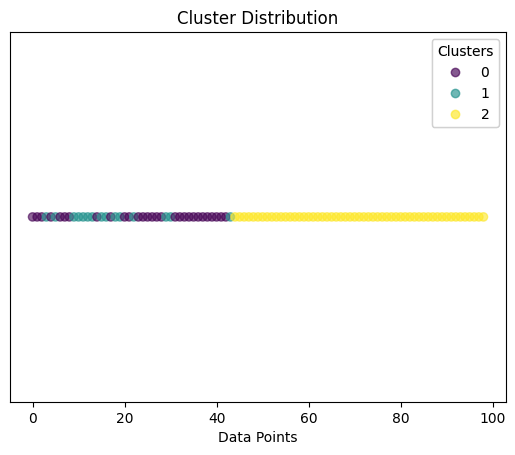

In [14]:
fig, ax = plt.subplots()
scatter = ax.scatter(range(len(final_dataset)), [0]*len(final_dataset), c=final_dataset['Cluster'], cmap='viridis', alpha=0.6)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.xlabel('Data Points')
plt.title('Cluster Distribution')
plt.yticks([])
plt.show()

## Analysis of Clusters
Print the top terms in each cluster to understand the themes within each group. Review the specific feedback categorized in each cluster to gain deeper insights.

In [15]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(n_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_terms)}")

for i in range(n_clusters):
    print(f"\nCluster {i} reasons:")
    print(unsatisfactory_answers[unsatisfactory_answers['Cluster'] == i]['Additional Feedback'].tolist())

Top terms per cluster:
Cluster 0: xi, accurate, china, would, broad, response, statement, overall, sure, mention
Cluster 1: context, similar, good, true, prompt, reiteration, issue, model, summarizes, summary

Cluster 0 reasons:
['broad', 'this answer is not in line with Chinese policy on N Korea or the West', 'China trades and sells "dual use" tech but no known mil hardware ', 'no mention of Australia and the context is about the future of communism ', 'good. not sure about short selling', 'accurate but broad - maybe due to parameters. if fit for parmenters a 10.', 'this is off - the meeting between Biden and Xi did not focus on China and Portugal and the policy for Macau. This is the largest deviation. With robust existing data on U.S. and China dialogue to guide it', 'it is a term widely used - no evidence of refrain - is this an example refrain being a common word that pushes the info in the wrong direction', 'not in Xi Jinping perspective - well   the model does fine but hard to g

## Export Results
Export the final dataset with cluster labels for further analysis or integration into customer service improvement strategies.

In [16]:
final_dataset.to_csv('training_dataset.csv')

##Results

###Cluster 0: Issues with Specificity and Relevance

<ul>
<li>Contextual Errors: Some responses contained factual inaccuracies or misrepresentations of current events or policies, particularly concerning China's geopolitical actions and stances.</li>
<li>Irrelevance: Occasionally, responses included irrelevant information, such as mentioning countries or concepts not pertinent to the question, leading to confusion or perceived inaccuracy.</li>
</ul>

###Cluster 1: Problems with Response Depth and Novelty
<ul>
<li>Over-Summarization: Many responses merely rephrased or summarized the input without adding any new information or insight, leading to dissatisfaction with the lack of depth.</li>
<li>Lack of Novelty: Responses often lacked original thought or interpretation, which was expected by users. Instead, the output mirrored the input too closely without providing additional value.
</li>
</ul>